# Projeto 4 - Séries Temporais

## Autor: Sandro Saorin da Silva

## 

## Descrição do Projeto

O conjunto de dados `series.csv`, consiste em dados de uma série temporal onde pode-se detalhar as seguintes variáveis:

<br>

- `DATE` - Marcação da data das vendas;
- `CATEGORY` - Identificação da categoria do produto;
- `UNITS_SOLD` - Quantidade de produtos vendidos por categoria diariamente.

<br>

O objetivo consiste em desenvolver um modelo de _Forecasting_ para a previsão de 3 semanas (21 dias) a nível diário, utilizando o histórico das categorias.

## 

## Desenvolvimento do Projeto

O desenvolvimento deste projeto será direcionado ao longo dos seguintes passos:
    
<br>

- Tratamento, Análise e Avaliação dos Dados;
- Determinação dos parâmetros para um modelo SARIMAX;
- Validação do Modelo utilizando _Splits_ de diferentes tamanhos;
- Predição nos dados de teste e gerações de novas predições.

<br><br>

### Tratamento, Análise e Avaliação dos Dados

Para um _Forecasting_ mais acurado em cada uma das categorias, o idela será separar as categorias e desenvolver um modelo para cada uma destas categorias, pois assim é possível modelar cada um desses mercado de maneira mais precisa e coerente.

In [1]:
# Bibliotecas necessárias para o projeto

# Bibliotecas comuns de utilização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para o  TIme Series / Forecasting
from pmdarima import auto_arima
import scipy.stats as ss
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

# Ignora eventuais warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o conjunto de dados
series = pd.read_csv('series.csv')

# visualizando o conjunto de dados
series.head(10)

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61
5,CATEG-3,2018-10-18,1
6,CATEG-3,2021-06-26,1462
7,CATEG-2,2020-08-23,28
8,CATEG-1,2020-03-28,26
9,CATEG-3,2020-06-11,1373


#### Tratamento, Análise e Avaliação dos Daods

In [3]:
# Visualizando os registros por categoria
series['CATEGORY'].value_counts()

CATEG-3    920
CATEG-1    887
CATEG-2    879
Name: CATEGORY, dtype: int64

Para o projeto será desenvolvido integralmente para a __Categoria 1__ e depois replicados as aplicações para as demais categorias.

Primeiro ponto será separar o conjunto de dados pela variável `CATEGORY` e ajustar o conjunto de dados para que seja usado como _index_ as datas das vendas.

In [17]:
# Separação dos dados entre as categorias
series_cat1 = series.loc[series['CATEGORY'] == 'CATEG-1', ['DATE', 'UNITS_SOLD']]

# Ordena os dados de acordo com as datas
series_cat1.sort_values(by = 'DATE', inplace = True)

# Transforma a coluna DATE para datetime
series_cat1['DATE'] = pd.to_datetime(series_cat1['DATE'])

# Define a coluna DATE como index
series_cat1.set_index('DATE', inplace = True)

# Mostra uma previa de como ficou as transofrmações
series_cat1.head()

,UNITS_SOLD
DATE,
2018-10-16,1
2019-06-11,27
2019-06-12,26
2019-06-13,24
2019-06-14,18


In [18]:
# Ajustando para que não falte datas
# cria todas as datas entre ominimo e o maximo
idx1 = pd.date_range(start = series_cat1.index.min(), end = series_cat1.index.max(), freq = 'D')

# Aplica o novo index ao conjunto de dados
series_cat1 = series_cat1.reindex(idx1)

# Preenche os faltantes com 0
series_cat1.fillna(0, inplace = True)

# PRevia dos dados
series_cat1.head()

,UNITS_SOLD
2018-10-16,1.0
2018-10-17,0.0
2018-10-18,0.0
2018-10-19,0.0
2018-10-20,0.0


Avaliando o histórico de unidades vendidas para a categoria 1:

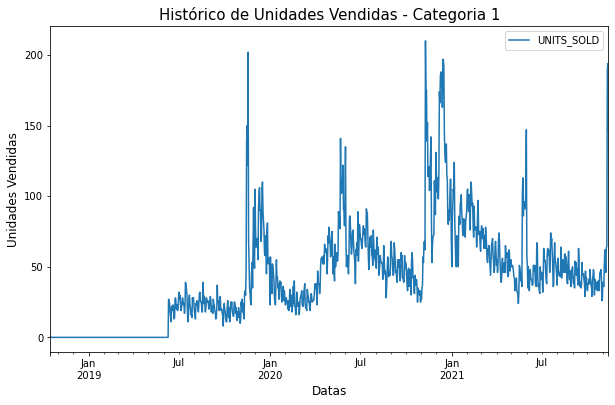

In [19]:
# Plot da serie temporal
series_cat1.plot(figsize = (10, 6))

# Cria um titulo
plt.title('Histórico de Unidades Vendidas - Categoria 1', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Mostra o gráfico
plt.show()

Note que como parte do tratamento dos dados, foram criadas datas e atribuídas como zero para vendas entre Janeiro e final de Junho / 2019. Dessa forma, será removido este período do conjunto de dados para evitar ruídos na modelagem e adequação a série temporal.

In [20]:
# Identificar o primeiro elemento maior que zero para filtrar os dados
time1 = series_cat1.loc[series_cat1['UNITS_SOLD'] > 0].index[1]

# Mostra a data
time1

Timestamp('2019-06-11 00:00:00')

In [21]:
# Filtrando o conjunto de dados
series_cat1 = series_cat1.loc[series_cat1.index >= time1]

Gráfico agora só com o período considerado:

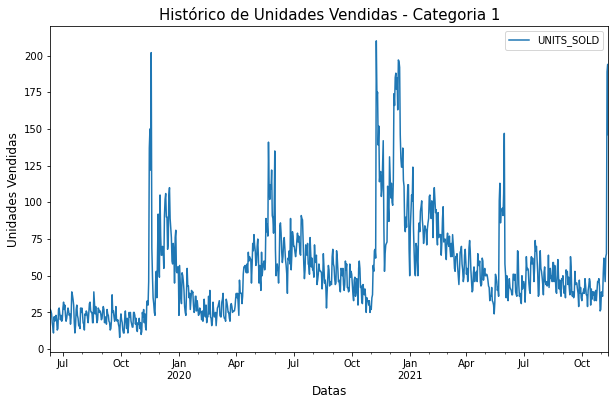

In [22]:
# Plot da serie temporal
series_cat1.plot(figsize = (10, 6))

# Cria um titulo
plt.title('Histórico de Unidades Vendidas - Categoria 1', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Mostra o gráfico
plt.show()

O próximo tópico seria justamente entre como está a distribuição desses dados utilizando de gráficos como histograma e _Q-Q Plot_. Para isso, desenvolveu-se uma função que cria estes gráficos:

In [23]:
# Cria uma função para o histograma e o Q-Q plot
def dist_ts(ts, lab = '', bins = 40):
    # cria dois subplots lado a lado
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (7, 3))
    
    # Histograma com a label
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histograma de ' + lab)
    
    # Plot do gráfico Q-Q
    ss.probplot(ts, plot = ax2)

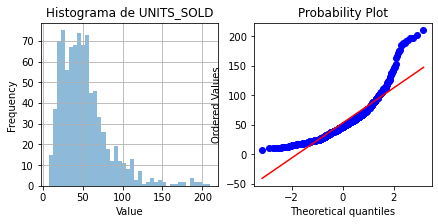

In [24]:
# Histograma e gráfico Q-Q para a categoria 1
dist_ts(series_cat1['UNITS_SOLD'], 'UNITS_SOLD')

Percebe-se que a dritribuição tem uma caracteristica bem assimétrica onde os valores _outliers_ destoam bastante para que a distribuição seja mais próxima de uma distribuição normal. Principalmente o efeito dos valores _outliers_ vai dificultar a aderência de um modelo estatístico para o _Forecasting_.

Uma forma de minimizar o efeito do _outliers_ e melhor distribuir os dados para algo mais parecido de uma normal seria aplicando uma transformação no conjunto de dados, neste caso foi escolhido aplicar uma tranformação na base `ln`:

In [25]:
# transforma os dados utilizando o ln
series_cat1.loc[:, 'log_UNITS_SOLD'] = np.log(series_cat1['UNITS_SOLD'])

In [26]:
series_cat1

,UNITS_SOLD,log_UNITS_SOLD
2019-06-11,27.0,3.295837
2019-06-12,26.0,3.258097
2019-06-13,24.0,3.178054
2019-06-14,18.0,2.890372
2019-06-15,15.0,2.708050
...,...,...
2021-11-08,63.0,4.143135
2021-11-09,65.0,4.174387
2021-11-10,189.0,5.241747
2021-11-11,194.0,5.267858


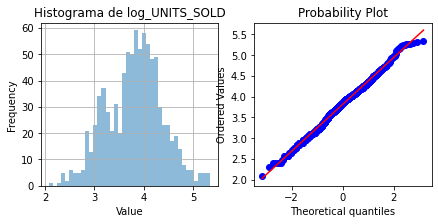

In [27]:
# Nova avaliação dos dados
dist_ts(series_cat1['log_UNITS_SOLD'], 'log_UNITS_SOLD')

Note agora que com a transformação dos dados na base `ln`, os dados ficaram em uma distribuição bem mais parecida com uma distribuição normal com pouco pontos que não aderem ao conjunto de dados. Este processo vai ser um facilitador na definição do melhor modelo que se adeque aos dados.

#### Determinando os parâmetros para o modelo SARIMAX

In [28]:
# Verificando os dados
series_cat1.head()

,UNITS_SOLD,log_UNITS_SOLD
2019-06-11,27.0,3.295837
2019-06-12,26.0,3.258097
2019-06-13,24.0,3.178054
2019-06-14,18.0,2.890372
2019-06-15,15.0,2.708050


O modelo conhecido do `statsmodels` como __SARIMAX__, seria um modelo ARIMA onde será considerado a sazonalidade. O modelo ARIMA é um modelo estatístico para Séries Temporais que compôe de 3 tipos de modelos para a caracterização da série:

<br>

- __Modelos Autoregressivos (AR):__ é a componente que leva em consideração a autocorrelação dos dados com eles mesmos quando levado em consideração _flags_ (ou chamadas defasagens) no período de tempo dos dados;

- __Modelo Intergrativo (I):__ é a componente que leva em consideração a estacionariedade da série. Para ser possível fazer o _Forecasting_ é necessário que a uma determinada série seja estacionária, e o modelo integrativo força este efeito pegando as diferenças da variável y entre ela mesma considerando també uma defasagem de tempo;

- __Modelo de Médias Móveis (MA):__ é a componente que faz o ponderamento dos dados de acordo com a média em uma janela de dias deslizante, ou seja, efeitos de picos e vales são atenuados ao longo da série devido a utilização da média.

<br>

Para determinar a melhor combinação de parâmetros para tanto o modelo ARIMA como a sanozalidade (efeito cíclico com intervalo de tempo bem definido), será utilizado a biblioteca `auto_arima` que testa diversas combinações e devolva a combinação que melhor de adequa ao conjunto de dados:

In [29]:
# Aplica o Auto Arima
stepwise_fit1 = auto_arima(series_cat1['log_UNITS_SOLD'], 
                          start_p = 0, 
                          start_q = 0,
                          max_p = 3, 
                          max_q = 3, 
                          m = 7,
                          seasonal = True,
                          trace = True,
                          error_action = 'ignore',   
                          suppress_warnings = True,  
                          stepwise = False)           

# Sumário do Auto Arima
stepwise_fit1.summary()

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=56.002, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-36.911, Time=0.22 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-86.989, Time=0.42 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-91.441, Time=0.22 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-168.294, Time=0.59 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=24.018, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-68.394, Time=0.35 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-124.752, Time=0.77 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-126.259, Time=0.36 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-211.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  886
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 190.666
Date:                           Wed, 10 Aug 2022   AIC                           -367.332
Time:                                   08:50:41   BIC                           -333.833
Sample:                                        0   HQIC                          -354.525
                                           - 886                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.637e-07   1.63e-05      0.022      0.982   -3.16e-05    3.23e-05
ar.L1          0.6979      0.032     21.953      0.000       0.636       0.760
ar.L2          0.1292      0.030      4.380      0.000       0.071       0.187
ma.L1         -0.9435      0.026    -36.735      0.000      -0.994      -0.893
ar.S.L7        0.9942      0.003    368.176      0.000       0.989       1.000
ma.S.L7       -0.9202      0.016    -56.523      0.000      -0.952      -0.888
sigma2         0.0370      0.001     40.534      0.000       0.035       0.039
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              1444.34
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A melhor combinação escolhida para o SARIMA foi (2, 1, 1) com uma sazonalidade (1, 0, 1, 7):

In [30]:
# Gera o modelo SARIMAX
model1 = sm.tsa.statespace.SARIMAX(series_cat1['log_UNITS_SOLD'], 
                                  order = (2, 1, 1), 
                                  seasonal_order = (1, 0, 1, 7))

# Fit do Modelo
results1 = model1.fit()

# Sumário do Modelo
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    log_UNITS_SOLD   No. Observations:                  886
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 192.312
Date:                           Wed, 10 Aug 2022   AIC                           -372.624
Time:                                   08:50:43   BIC                           -343.910
Sample:                               06-11-2019   HQIC                          -361.646
                                    - 11-12-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7363      0.022     33.633      0.000       0.693       0.779
ar.L2          0.1755      0.025      7.006      0.000       0.126       0.225
ma.L1         -0.9926      0.007   -140.518      0.000      -1.006      -0.979
ar.S.L7        0.9975      0.002    655.137      0.000       0.995       1.000
ma.S.L7       -0.9264      0.016    -58.829      0.000      -0.957      -0.896
sigma2         0.0381      0.001     39.035      0.000       0.036       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              1441.91
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Validação do Modelo utilizando Splits de Diferentes Tamanhos

A validação do modelo será feita utilizando de _splits_ (parttes) de diferentes tamanhos, ou seja, partindo do ponto inicial da série, será testado conjuntos de dados com diferentes quantidade de dados de maneira a ver progressivamente como se comporta o erro na predição desta seria, isto levando em consideração uma janela de validação de 21 dias.

Foi desenvolvido duas funções que fazem o o papel de gerar as separações, treinar o modelo, criar a predições e determinar o erro respectivamente:

In [31]:
# One-Step Sarima Forecast
def sarima_forecast(history, order, sorder):
    # Define o SARIMA
    model = sm.tsa.statespace.SARIMAX(history, 
                                      order = order, 
                                      seasonal_order = sorder
                                      )
    
    # Fit do Modelo
    model_fit = model.fit(disp=False)
    
    # Faz uma predição com o Sarima e retorna este valor
    yhat = model_fit.predict(len(history), len(history))
    
    # Retorna a predição
    return yhat[0]
 
# Função para fazer a validação com splits de diferentes comprimentos
def time_series_split(data, length, cv, window_val, order, sorder):
    # Define uma lista vazia para os erros
    list_errors = list()
    
    # Define o tamanho dos folds de acordo com o cv
    size_steps = int(length/cv)
    
    # Loop nos splits do dados
    for i in range(cv):
        # Define uma lista vazia para as predições
        predictions = list()
        
        # Separa os dados em treino e teste
        train = data[:(i + 1)*size_steps - window_val] 
        test = data[size_steps - window_val:size_steps]
        
        # cria o historico com os dados de treino
        history = [x for x in train]
        
        # Loop nos dados de teste para gerar as predições
        for j in range(len(test)):
            # Fit do modelo e gera a predição
            yhat = sarima_forecast(history, order, sorder)
            # salva as predições
            predictions.append(yhat)
            # atualiza o historico com o dado de teste atual
            history.append(test[j])
            
        # Calcula o MAPE para a iteração    
        errors = mean_absolute_percentage_error(test.values, predictions)
        # Salva o valor em uma lista de erros
        list_errors.append(errors)
    
    # Retorna os erros em cada um dos folds
    return list_errors

In [32]:
# Define a order e o seasonal_order de acordo com o auto_arima
order1 = (2, 1, 1)
seasonal_order1 = (1, 0, 1, 7)

# Utiliza a função para testar composições diferentes dos dados
errors1 = time_series_split(series_cat1['log_UNITS_SOLD'],
                           len(series_cat1['log_UNITS_SOLD']),
                           7,
                           21, 
                           order1, 
                           seasonal_order1)

Utilizou-se como métrica de acompanhamento o _MAPE_ (_Mean Absolute Percentage Error_) que funciona como uma acurácia para série temporal levando em consideração a diferença entre o predito e o valor real:

In [33]:
# MAPE em cada uma das separações com um cv = 7
errors1

[0.07411367890936327,
 0.08785648520907481,
 0.12937453469476243,
 0.10167820916451002,
 0.12863349665154958,
 0.11127181054226194,
 0.1022725529892041]

Utilizando de 7 separações, note-se que o _MAPE_ assume valores entre 7 a 12% de erro, o que demonstra uma boa qualidade na identificação do comportamento da série temporal.

#### Predição para os dados de Teste e gerando novas previsões

Por fim para a Categoria 1, será feita uma separação entre treino e teste, deixando 21 um dias para teste. Onde agora iremos gerar predições com o modelo e comparar com o resultado esperado.

Após isso, será gerados as previsões para 21 dias futuros em relação a base de dados:

In [34]:
# Separa os dados em treino e teste a partir de um tamanho de janela
window_size = 21

# Separa os dados de fato
train1 = series_cat1.iloc[:-window_size]
test1  = series_cat1.iloc[-window_size:]

# Print dos Shapes
print('Quantidade total dos dados: ', series_cat1.shape)
print('Dados para Treinamento:     ', train1.shape)
print('Dados para Teste:           ', test1.shape)

Quantidade total dos dados:  (886, 2)
Dados para Treinamento:      (865, 2)
Dados para Teste:            (21, 2)


In [35]:
# Define inicio e fim para as predições
start1 = len(train1)
end1   = len(train1) + len(test1) - 1

# Obtendo as predições
predicts1 = results1.predict(start = start1, 
                             end = end1, 
                             dynamic = False, 
                             typ = 'levels').rename('Previsões')

# Ajustando o index das predições
predicts1.index = test1.index

In [36]:
# Vamos fazer um comparativo entre predito e esperado
for i in range(len(predicts1)):
    print(f"predito = {predicts1[i]:<6.4}, esperado = {test1['log_UNITS_SOLD'][i]:<6.4}")

predito = 3.544 , esperado = 3.689 
predito = 3.624 , esperado = 3.497 
predito = 3.836 , esperado = 3.689 
predito = 3.662 , esperado = 3.829 
predito = 3.765 , esperado = 3.829 
predito = 3.747 , esperado = 3.871 
predito = 3.79  , esperado = 3.761 
predito = 3.712 , esperado = 3.258 
predito = 3.316 , esperado = 3.296 
predito = 3.599 , esperado = 3.664 
predito = 3.619 , esperado = 3.611 
predito = 3.602 , esperado = 3.584 
predito = 3.535 , esperado = 3.951 
predito = 3.803 , esperado = 4.127 
predito = 3.965 , esperado = 3.989 
predito = 3.922 , esperado = 3.829 
predito = 4.127 , esperado = 4.143 
predito = 4.069 , esperado = 4.174 
predito = 4.105 , esperado = 5.242 
predito = 4.898 , esperado = 5.268 
predito = 5.1   , esperado = 4.984 


In [37]:
# Retorna da base ln utilizando o e^x
predicts_inverse1 = np.e**(predicts1)

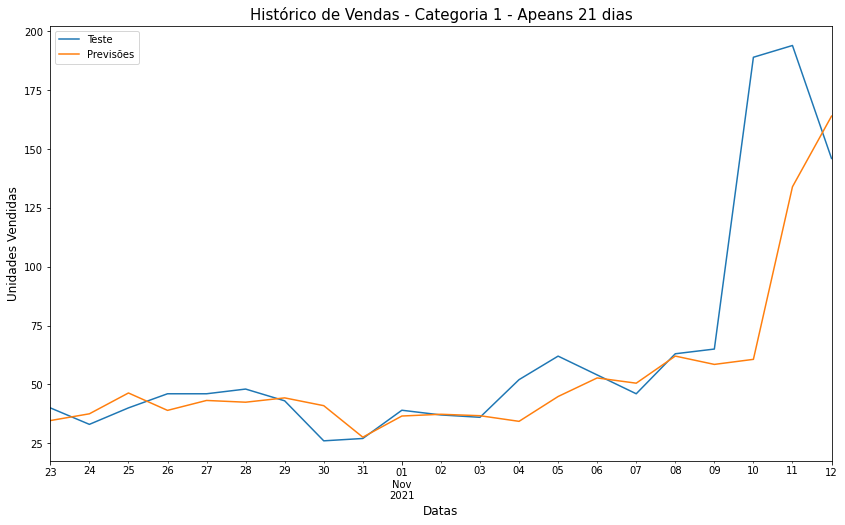

In [38]:
# Plot do Gráfico para os 21 dias
# Define o tamanho da figura
plt.figure(figsize = (14, 8))

# Define o titulo do gráfico
plt.title('Histórico de Vendas - Categoria 1 - Apeans 21 dias', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Cria os gráficos 
test1['UNITS_SOLD'].plot(legend = True, label = 'Teste')
predicts_inverse1.plot(legend = True)

# Mostra o gráfico
plt.show()

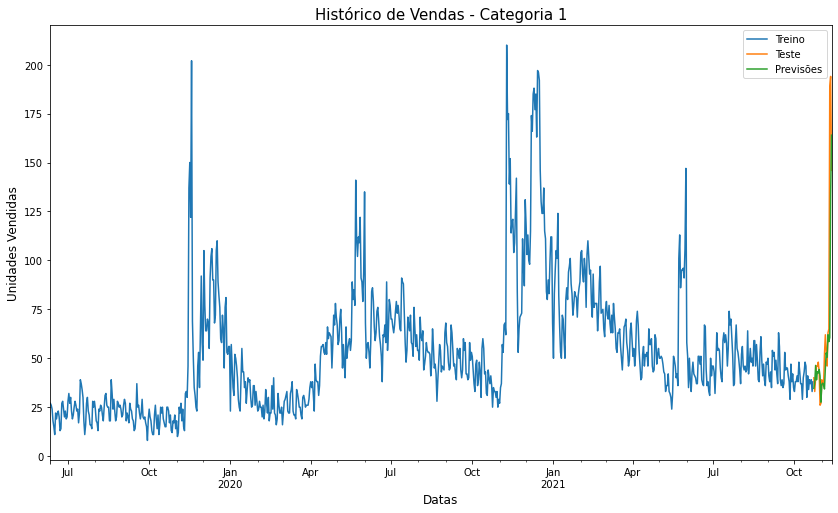

In [39]:
# Plot do Gráfico Completo
# Define o tamanho da figura
plt.figure(figsize = (14, 8))

# Define o titulo do gráfico
plt.title('Histórico de Vendas - Categoria 1', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Cria os gráficos 
train1['UNITS_SOLD'].plot(legend = True, label = 'Treino')
test1['UNITS_SOLD'].plot(legend = True, label = 'Teste')
predicts_inverse1.plot(legend = True)

# Mostra o gráfico
plt.show()

A partir do comparativo entre preditos e esperados e pelos gráficos, nota-se que ficou bem adequado a aderência do modelo SARIMA a série temporal. Resta agora gerar as predições para dados futuros:

In [40]:
# Definindo a nova janela de predições para 21 dias
start1 = len(series_cat1)
end1   = len(series_cat1) + 21

# Obtendo as  novas predições
new_predicts1 = results1.predict(start = start1, 
                                 end = end1, 
                                 dynamic = False, 
                                 typ = 'levels').rename('Novas Previsões')

In [41]:
# Retornando da base ln utilizando o e^x
new_predicts_inverse1 = np.e**(new_predicts1)

# visualiza as novas predições
new_predicts_inverse1

2021-11-13    126.323988
2021-11-14    110.107469
2021-11-15    138.395075
2021-11-16    123.865899
2021-11-17    122.520908
2021-11-18    112.160945
2021-11-19    100.644211
2021-11-20     87.299194
2021-11-21     78.618686
2021-11-22    101.176164
2021-11-23     92.730185
2021-11-24     93.720953
2021-11-25     87.545311
2021-11-26     80.042374
2021-11-27     70.651835
2021-11-28     64.658994
2021-11-29     84.386510
2021-11-30     78.415895
2021-12-01     80.253534
2021-12-02     75.855241
2021-12-03     70.120716
2021-12-04     62.533785
Freq: D, Name: Novas Previsões, dtype: float64

Os passos a seguir, seguindo a mesma lógica de raciocínio da Categoria 1, será replicar os mesmos conhecimentos e técnicas para as categorias 2 e 3, gerando por fim as suas devidas predições.

## 

### Categoria 2

In [42]:
# Separação dos dados entre as categorias
series_cat2 = series.loc[series['CATEGORY'] == 'CATEG-2', ['DATE', 'UNITS_SOLD']]

# Ordena os dados de acordo com as datas
series_cat2.sort_values(by = 'DATE', inplace = True)

# Transforma a coluna DATE para datetime
series_cat2['DATE'] = pd.to_datetime(series_cat2['DATE'])

# Define a coluna DATE como index
series_cat2.set_index('DATE', inplace = True)

# Mostra uma previa de como ficou as transofrmações
series_cat2.head()

,UNITS_SOLD
DATE,
2018-10-16,1
2019-06-11,15
2019-06-12,13
2019-06-13,8
2019-06-14,9


In [43]:
# Ajustando para que não falte datas
# cria todas as datas entre ominimo e o maximo
idx2 = pd.date_range(start = series_cat2.index.min(), end = series_cat2.index.max(), freq = 'D')

# Aplica o novo index ao conjunto de dados
series_cat2 = series_cat2.reindex(idx2)

# Preenche os faltantes com 0
series_cat2.fillna(0, inplace = True)

# PRevia dos dados
series_cat2.head()

,UNITS_SOLD
2018-10-16,1.0
2018-10-17,0.0
2018-10-18,0.0
2018-10-19,0.0
2018-10-20,0.0


Avaliando o histórico de unidades vendidas para a categoria 2:

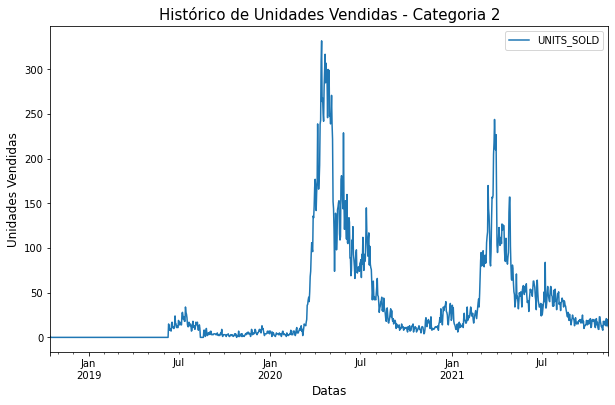

In [44]:
# Plot da serie temporal
series_cat2.plot(figsize = (10, 6))

# Cria um titulo
plt.title('Histórico de Unidades Vendidas - Categoria 2', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Mostra o gráfico
plt.show()

In [45]:
# Identificar o primeiro elemento maior que zero para filtrar os dados
time2 = series_cat2.loc[series_cat2['UNITS_SOLD'] > 0].index[1]

# Mostra a data
time2

Timestamp('2019-06-11 00:00:00')

In [46]:
# Filtrando o conjunto de dados
series_cat2 = series_cat2.loc[series_cat2.index >= time2]

Gráfico agora só com o período considerado:

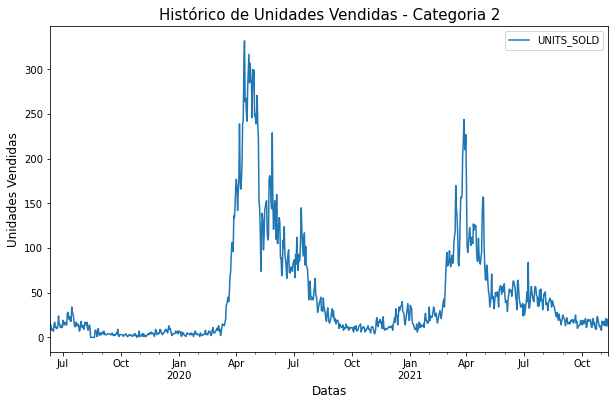

In [47]:
# Plot da serie temporal
series_cat2.plot(figsize = (10, 6))

# Cria um titulo
plt.title('Histórico de Unidades Vendidas - Categoria 2', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Mostra o gráfico
plt.show()

O próximo tópico seria justamente entre como está a distribuição desses dados utilizando de gráficos como histograma e _Q-Q Plot_. Para isso, desenvolveu-se uma função que cria estes gráficos:

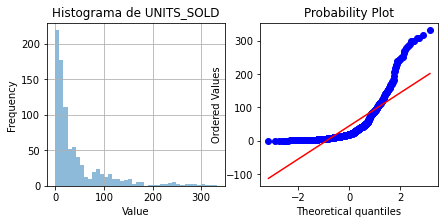

In [48]:
# Histograma e gráfico Q-Q para a categoria 1
dist_ts(series_cat2['UNITS_SOLD'], 'UNITS_SOLD')

Percebe-se que a dritribuição tem uma caracteristica bem assimétrica onde os valores _outliers_ destoam bastante para que a distribuição seja mais próxima de uma distribuição normal. Principalmente o efeito dos valores _outliers_ vai dificultar a aderência de um modelo estatístico para o _Forecasting_.

Uma forma de minimizar o efeito do _outliers_ e melhor distribuir os dados para algo mais parecido de uma normal seria aplicando uma transformação no conjunto de dados, neste caso foi escolhido aplicar uma tranformação na base `ln`:

In [49]:
# transforma os dados utilizando o ln
series_cat2.loc[:, 'log_UNITS_SOLD'] = np.where(series_cat2['UNITS_SOLD'] <=0 , 0, np.log(series_cat2['UNITS_SOLD']))

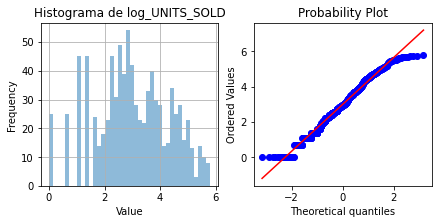

In [50]:
# Nova avaliação dos dados
dist_ts(series_cat2['log_UNITS_SOLD'], 'log_UNITS_SOLD')

Mesmo aplicando a base `ln` o efeito dos _outliers_ é significativo, podendo dificultar a aderência do modelo. Será testado com uma transformação de raiz cúbica `cbrt`:

In [51]:
series_cat2.loc[:, 'cbrt_UNITS_SOLD'] = np.cbrt(series_cat2['UNITS_SOLD'])

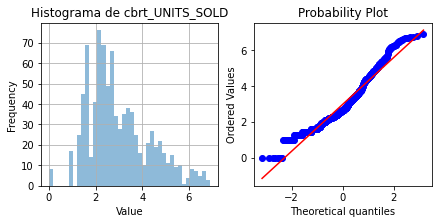

In [52]:
# Nova avaliação dos dados
dist_ts(series_cat2['cbrt_UNITS_SOLD'], 'cbrt_UNITS_SOLD')

Com a transformação com a raiz cúbica ficou melhor a normalização dos dados, portanto esta transformação irá prosseguir para que a determinação do modelo.

#### Determinando os parâmetros para o modelo SARIMAX

In [53]:
# Verificando os dados
series_cat2.head()

,UNITS_SOLD,log_UNITS_SOLD,cbrt_UNITS_SOLD
2019-06-11,15.0,2.708050,2.466212
2019-06-12,13.0,2.564949,2.351335
2019-06-13,8.0,2.079442,2.000000
2019-06-14,9.0,2.197225,2.080084
2019-06-15,9.0,2.197225,2.080084


In [54]:
# Aplica o Auto Arima
stepwise_fit2 = auto_arima(series_cat2['cbrt_UNITS_SOLD'], 
                          start_p = 0, 
                          start_q = 0,
                          max_p = 3, 
                          max_q = 3, 
                          m = 7,
                          seasonal = True,
                          trace = True,
                          error_action = 'ignore',   
                          suppress_warnings = True,  
                          stepwise = False)           

# Sumário do Auto Arima
stepwise_fit2.summary()

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=384.550, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=376.382, Time=0.20 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=364.054, Time=0.37 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=373.542, Time=0.17 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=358.182, Time=0.32 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=348.889, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=340.261, Time=0.29 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=323.218, Time=0.53 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=336.735, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=312.781

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  886
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -118.685
Date:                           Wed, 10 Aug 2022   AIC                            249.369
Time:                                   08:56:52   BIC                            278.083
Sample:                                        0   HQIC                           260.347
                                           - 886                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.909e-05      0.001     -0.055      0.956      -0.001       0.001
ar.L1          0.1340      0.104      1.283      0.199      -0.071       0.339
ma.L1         -0.4214      0.099     -4.260      0.000      -0.615      -0.228
ar.S.L7        0.9475      0.024     40.185      0.000       0.901       0.994
ma.S.L7       -0.8603      0.037    -23.097      0.000      -0.933      -0.787
sigma2         0.0764      0.002     40.565      0.000       0.073       0.080
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              3142.26
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A melhor combinação escolhida para o SARIMA foi (1, 1, 1) com uma sazonalidade (1, 0, 2, 7):

In [57]:
# Gera o modelo SARIMAX
model2 = sm.tsa.statespace.SARIMAX(series_cat2['cbrt_UNITS_SOLD'], 
                                   order = (1, 1, 1), 
                                   seasonal_order = (1, 0, 2, 7))

# Fit do Modelo
results2 = model2.fit()

# Sumário do Modelo
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                        cbrt_UNITS_SOLD   No. Observations:                  886
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -105.740
Date:                                Wed, 10 Aug 2022   AIC                            223.480
Time:                                        08:58:40   BIC                            252.194
Sample:                                    06-11-2019   HQIC                           234.458
                                         - 11-12-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2170      0.093      2.345      0.019       0.036       0.398
ma.L1         -0.5084      0.084     -6.032      0.000      -0.674      -0.343
ar.S.L7        0.9992      0.001    776.421      0.000       0.997       1.002
ma.S.L7       -1.0115      0.023    -43.294      0.000      -1.057      -0.966
ma.S.L14       0.0284      0.024      1.208      0.227      -0.018       0.075
sigma2         0.0733      0.002     36.925      0.000       0.069       0.077
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2473.21
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Validação do Modelo utilizando Splits de Diferentes Tamanhos

A validação do modelo será feita utilizando de _splits_ (parttes) de diferentes tamanhos, ou seja, partindo do ponto inicial da série, será testado conjuntos de dados com diferentes quantidade de dados de maneira a ver progressivamente como se comporta o erro na predição desta seria, isto levando em consideração uma janela de validação de 21 dias.

Foi desenvolvido duas funções que fazem o o papel de gerar as separações, treinar o modelo, criar a predições e determinar o erro respectivamente:

In [58]:
# Define a order e o seasonal_order de acordo com o auto_arima
order2 = (0, 1, 2)
seasonal_order2 = (1, 0, 2, 7)

# Utiliza a função para testar composições diferentes dos dados
errors2 = time_series_split(series_cat2['cbrt_UNITS_SOLD'],
                           len(series_cat2['cbrt_UNITS_SOLD']),
                           7,
                           21, 
                           order2, 
                           seasonal_order2)

Utilizou-se como métrica de acompanhamento o _MAPE_ (_Mean Absolute Percentage Error_) que funciona como uma acurácia para série temporal levando em consideração a diferença entre o predito e o valor real:

In [59]:
# MAPE em cada uma das separações com um cv = 7
errors2

[0.15557737104808278,
 0.1369858084591406,
 0.2695219023863594,
 0.1513699079308041,
 0.19487776213354274,
 0.2128168749284677,
 0.16397447353833783]

Utilizando de 7 separações, note-se que o _MAPE_ assume valores entre 7 a 12% de erro, o que demonstra uma boa qualidade na identificação do comportamento da série temporal.

#### Predição para os dados de Teste e gerando novas previsões

In [60]:
# Separa os dados em treino e teste a partir de um tamanho de janela
window_size = 21

# Separa os dados de fato
train2 = series_cat2.iloc[:-window_size]
test2  = series_cat2.iloc[-window_size:]

# Print dos Shapes
print('Quantidade total dos dados: ', series_cat2.shape)
print('Dados para Treinamento:     ', train2.shape)
print('Dados para Teste:           ', test2.shape)

Quantidade total dos dados:  (886, 3)
Dados para Treinamento:      (865, 3)
Dados para Teste:            (21, 3)


In [61]:
# Define inicio e fim para as predições
start2 = len(train2)
end2   = len(train2) + len(test2) - 1

# Obtendo as predições
predicts2 = results2.predict(start = start2, 
                             end = end2, 
                             dynamic = False, 
                             typ = 'levels').rename('Previsões')

# Ajustando o index das predições
predicts2.index = test2.index

In [62]:
# Vamos fazer um comparativo entre predito e esperado
for i in range(len(predicts2)):
    print(f"predito = {predicts2[i]:<6.4}, esperado = {test2['cbrt_UNITS_SOLD'][i]:<6.4}")

predito = 2.24  , esperado = 2.08  
predito = 2.215 , esperado = 2.08  
predito = 2.321 , esperado = 2.844 
predito = 2.702 , esperado = 2.844 
predito = 2.689 , esperado = 2.621 
predito = 2.585 , esperado = 2.466 
predito = 2.396 , esperado = 2.289 
predito = 2.284 , esperado = 2.351 
predito = 2.413 , esperado = 2.08  
predito = 2.365 , esperado = 2.0   
predito = 2.127 , esperado = 2.621 
predito = 2.416 , esperado = 2.571 
predito = 2.468 , esperado = 2.41  
predito = 2.3   , esperado = 2.621 
predito = 2.479 , esperado = 2.571 
predito = 2.599 , esperado = 2.351 
predito = 2.623 , esperado = 2.759 
predito = 2.725 , esperado = 2.351 
predito = 2.362 , esperado = 2.621 
predito = 2.534 , esperado = 2.714 
predito = 2.533 , esperado = 2.289 


In [63]:
# Retorna da base ln utilizando o e^x
predicts_inverse2 = (predicts2)**3

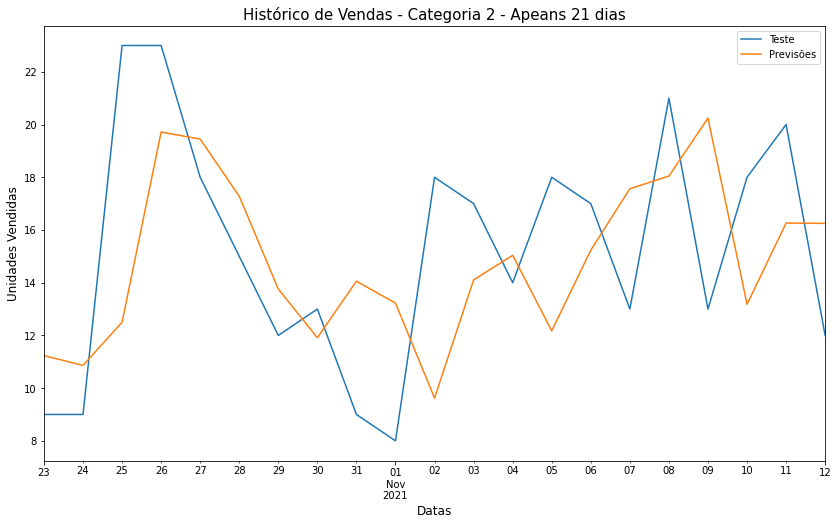

In [64]:
# Plot do Gráfico para os 21 dias
# Define o tamanho da figura
plt.figure(figsize = (14, 8))

# Define o titulo do gráfico
plt.title('Histórico de Vendas - Categoria 2 - Apeans 21 dias', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Cria os gráficos 
test2['UNITS_SOLD'].plot(legend = True, label = 'Teste')
predicts_inverse2.plot(legend = True)

# Mostra o gráfico
plt.show()

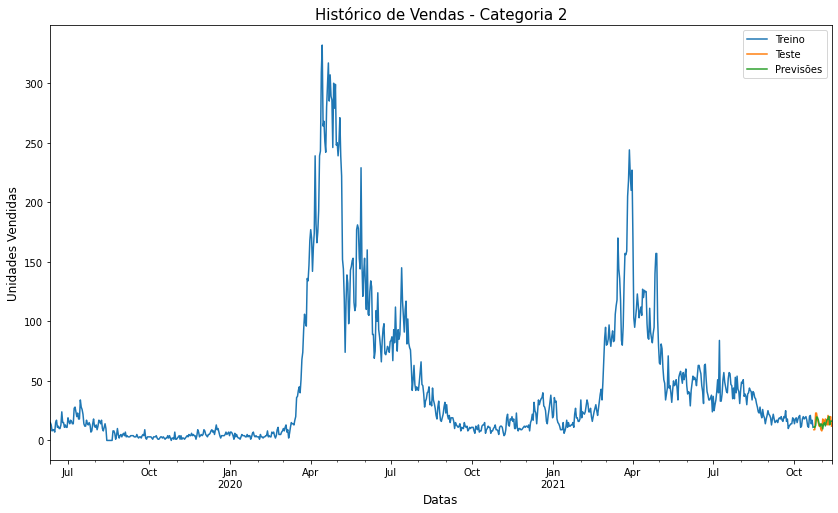

In [65]:
# Plot do Gráfico Completo
# Define o tamanho da figura
plt.figure(figsize = (14, 8))

# Define o titulo do gráfico
plt.title('Histórico de Vendas - Categoria 2', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Cria os gráficos 
train2['UNITS_SOLD'].plot(legend = True, label = 'Treino')
test2['UNITS_SOLD'].plot(legend = True, label = 'Teste')
predicts_inverse2.plot(legend = True)

# Mostra o gráfico
plt.show()

A partir do comparativo entre preditos e esperados e pelos gráficos, nota-se que ficou bem adequado a aderência do modelo SARIMA a série temporal. Resta agora gerar as predições para dados futuros:

In [66]:
# Definindo a nova janela de predições para 21 dias
start2 = len(series_cat2)
end2   = len(series_cat2) + 21

# Obtendo as  novas predições
new_predicts2 = results2.predict(start = start2, 
                                 end = end2, 
                                 dynamic = False, 
                                 typ = 'levels').rename('Novas Previsões')

In [67]:
# Retornando da base ln utilizando o e^x
new_predicts_inverse2 = (new_predicts2)**3

# visualiza as novas predições
new_predicts_inverse2

2021-11-13    12.179541
2021-11-14    13.515942
2021-11-15    17.253874
2021-11-16    17.570975
2021-11-17    15.703619
2021-11-18    14.974041
2021-11-19    13.152008
2021-11-20    12.392518
2021-11-21    13.386304
2021-11-22    17.156120
2021-11-23    17.231051
2021-11-24    15.579192
2021-11-25    14.919635
2021-11-26    12.958078
2021-11-27    12.232544
2021-11-28    13.222938
2021-11-29    16.961489
2021-11-30    17.036120
2021-12-01    15.398318
2021-12-02    14.744456
2021-12-03    12.800166
2021-12-04    12.081174
Freq: D, Name: Novas Previsões, dtype: float64

## 

### Categoria 3

In [68]:
# Separação dos dados entre as categorias
series_cat3 = series.loc[series['CATEGORY'] == 'CATEG-3', ['DATE', 'UNITS_SOLD']]

# Ordena os dados de acordo com as datas
series_cat3.sort_values(by = 'DATE', inplace = True)

# Transforma a coluna DATE para datetime
series_cat3['DATE'] = pd.to_datetime(series_cat3['DATE'])

# Define a coluna DATE como index
series_cat3.set_index('DATE', inplace = True)

# Mostra uma previa de como ficou as transofrmações
series_cat3.head()

,UNITS_SOLD
DATE,
2018-09-24,0
2018-09-25,0
2018-09-27,0
2018-09-28,2
2018-09-29,1


In [69]:
# Ajustando para que não falte datas
# cria todas as datas entre ominimo e o maximo
idx3 = pd.date_range(start = series_cat3.index.min(), end = series_cat3.index.max(), freq = 'D')

# Aplica o novo index ao conjunto de dados
series_cat3 = series_cat3.reindex(idx3)

# Preenche os faltantes com 0
series_cat3.fillna(0, inplace = True)

# PRevia dos dados
series_cat3.head()

,UNITS_SOLD
2018-09-24,0.0
2018-09-25,0.0
2018-09-26,0.0
2018-09-27,0.0
2018-09-28,2.0


Avaliando o histórico de unidades vendidas para a categoria 3:

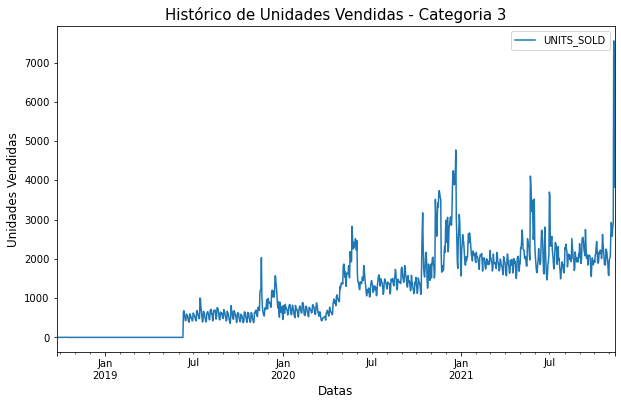

In [70]:
# Plot da serie temporal
series_cat3.plot(figsize = (10, 6))

# Cria um titulo
plt.title('Histórico de Unidades Vendidas - Categoria 3', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Mostra o gráfico
plt.show()

In [71]:
# Identificar o primeiro elemento maior que zero para filtrar os dados
time3 = series_cat3.loc[series_cat3['UNITS_SOLD'] > 10].index[0]

# Mostra a data
time3

Timestamp('2019-06-11 00:00:00', freq='D')

In [72]:
# Filtrando o conjunto de dados
series_cat3 = series_cat3.loc[series_cat3.index >= time3]

Gráfico agora só com o período considerado:

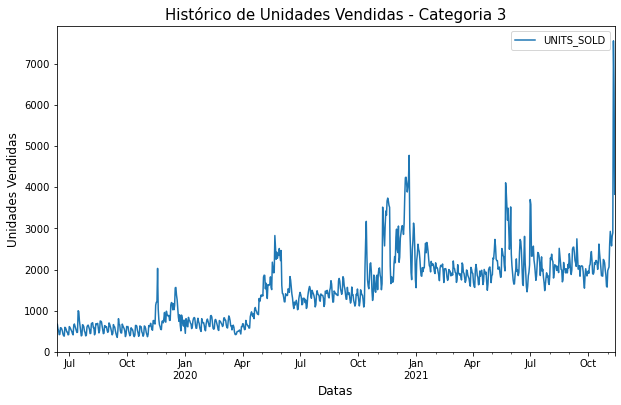

In [73]:
# Plot da serie temporal
series_cat3.plot(figsize = (10, 6))

# Cria um titulo
plt.title('Histórico de Unidades Vendidas - Categoria 3', fontsize = 15)

# Eixo X
plt.xlabel('Datas', fontsize = 12)

# Eixo y
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Mostra o gráfico
plt.show()

O próximo tópico seria justamente entre como está a distribuição desses dados utilizando de gráficos como histograma e _Q-Q Plot_. Para isso, desenvolveu-se uma função que cria estes gráficos:

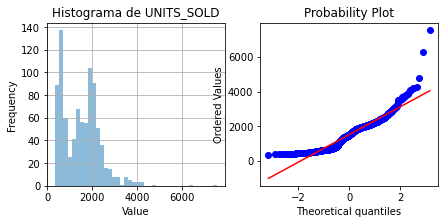

In [74]:
# Histograma e gráfico Q-Q para a categoria 3
dist_ts(series_cat3['UNITS_SOLD'], 'UNITS_SOLD')

Percebe-se que a dritribuição tem uma caracteristica bem assimétrica onde os valores _outliers_ destoam bastante para que a distribuição seja mais próxima de uma distribuição normal. Principalmente o efeito dos valores _outliers_ vai dificultar a aderência de um modelo estatístico para o _Forecasting_.

Uma forma de minimizar o efeito do _outliers_ e melhor distribuir os dados para algo mais parecido de uma normal seria aplicando uma transformação no conjunto de dados, neste caso foi escolhido aplicar uma tranformação na base `ln`:

In [75]:
# transforma os dados utilizando o ln
series_cat3.loc[:, 'log_UNITS_SOLD'] = np.log(series_cat3['UNITS_SOLD'])

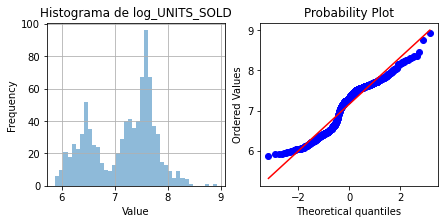

In [76]:
# Nova avaliação dos dados
dist_ts(series_cat3['log_UNITS_SOLD'], 'log_UNITS_SOLD')

Note agora que com a transformação dos dados na base `ln`, os dados ficaram em uma distribuição bem mais parecida com uma distribuição normal com pouco pontos que não aderem ao conjunto de dados. Este processo vai ser um facilitador na definição do melhor modelo que se adeque aos dados.

#### Determinando os parâmetros para o modelo SARIMAX

In [77]:
# Verificando os dados
series_cat3.head()

,UNITS_SOLD,log_UNITS_SOLD
2019-06-11,642.0,6.464588
2019-06-12,679.0,6.520621
2019-06-13,561.0,6.329721
2019-06-14,520.0,6.253829
2019-06-15,422.0,6.045005


In [78]:
# Aplica o Auto Arima
stepwise_fit3 = auto_arima(series_cat3['log_UNITS_SOLD'], 
                          start_p = 0, 
                          start_q = 0,
                          max_p = 3, 
                          max_q = 3, 
                          m = 7,
                          seasonal = True,
                          trace = True,
                          error_action = 'ignore',   
                          suppress_warnings = True,  
                          stepwise = False)           

# Sumário do Auto Arima
stepwise_fit3.summary()

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-753.511, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-921.151, Time=0.51 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1023.571, Time=0.54 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1054.196, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-1280.634, Time=0.87 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-1280.763, Time=1.62 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1164.244, Time=0.52 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-1281.204, Time=1.54 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=-1276.660, Time=2.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-759.731, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-925.346, Time=0.39 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1029.114, Time=1.03 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1057.999, Time=0.41 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-1281.564, Time=1.29 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-1282.003, Time=1.96 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  886
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 670.582
Date:                           Wed, 10 Aug 2022   AIC                          -1327.164
Time:                                   09:02:56   BIC                          -1293.665
Sample:                                        0   HQIC                         -1314.357
                                           - 886                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.806e-06   4.44e-05      0.153      0.878   -8.02e-05    9.38e-05
ar.L1          0.9422      0.037     25.620      0.000       0.870       1.014
ar.L2         -0.1698      0.029     -5.814      0.000      -0.227      -0.113
ma.L1         -0.9107      0.029    -31.501      0.000      -0.967      -0.854
ar.S.L7        0.9834      0.005    181.373      0.000       0.973       0.994
ma.S.L7       -0.8539      0.022    -39.521      0.000      -0.896      -0.812
sigma2         0.0127      0.000     52.801      0.000       0.012       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6425.96
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.59
Prob(H) (two-sided):                  0.60   Kurtosis:                        15.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A melhor combinação escolhida para o SARIMA foi (2, 1, 1) com uma sazonalidade (1, 0, 1, 7):

In [79]:
# Gera o modelo SARIMAX
model3 = sm.tsa.statespace.SARIMAX(series_cat3['log_UNITS_SOLD'], 
                                  order = (2, 1, 1), 
                                  seasonal_order = (1, 0, 1, 7))

# Fit do Modelo
results3 = model3.fit()

# Sumário do Modelo
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    log_UNITS_SOLD   No. Observations:                  886
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 673.233
Date:                           Wed, 10 Aug 2022   AIC                          -1334.467
Time:                                   09:02:57   BIC                          -1305.753
Sample:                               06-11-2019   HQIC                         -1323.489
                                    - 11-12-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9147      0.038     24.095      0.000       0.840       0.989
ar.L2         -0.1758      0.030     -5.910      0.000      -0.234      -0.117
ma.L1         -0.8919      0.030    -29.380      0.000      -0.951      -0.832
ar.S.L7        0.9952      0.002    466.317      0.000       0.991       0.999
ma.S.L7       -0.9061      0.017    -54.459      0.000      -0.939      -0.873
sigma2         0.0126      0.000     55.828      0.000       0.012       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              6846.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             1.66
Prob(H) (two-sided):                  0.63   Kurtosis:                        16.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Validação do Modelo utilizando Splits de Diferentes Tamanhos

A validação do modelo será feita utilizando de _splits_ (parttes) de diferentes tamanhos, ou seja, partindo do ponto inicial da série, será testado conjuntos de dados com diferentes quantidade de dados de maneira a ver progressivamente como se comporta o erro na predição desta seria, isto levando em consideração uma janela de validação de 21 dias.

Foi desenvolvido duas funções que fazem o o papel de gerar as separações, treinar o modelo, criar a predições e determinar o erro respectivamente:

In [80]:
# Define a order e o seasonal_order de acordo com o auto_arima
order3 = (2, 1, 1)
seasonal_order3 = (1, 0, 1, 7)

# Utiliza a função para testar composições diferentes dos dados
errors3 = time_series_split(series_cat3['log_UNITS_SOLD'],
                           len(series_cat3['log_UNITS_SOLD']),
                           7,
                           21, 
                           order3, 
                           seasonal_order3)

Utilizou-se como métrica de acompanhamento o _MAPE_ (_Mean Absolute Percentage Error_) que funciona como uma acurácia para série temporal levando em consideração a diferença entre o predito e o valor real:

In [81]:
# MAPE em cada uma das separações com um cv = 7
errors3

[0.00811036229292989,
 0.013387379147711344,
 0.028396640241632434,
 0.01958301677139908,
 0.02516461175924346,
 0.027166467424628655,
 0.028286981025504008]

Utilizando de 7 separações, note-se que o _MAPE_ assume valores entre 7 a 12% de erro, o que demonstra uma boa qualidade na identificação do comportamento da série temporal.

#### Predição para os dados de Teste e gerando novas previsões

In [82]:
# Separa os dados em treino e teste a partir de um tamanho de janela
window_size = 21

# Separa os dados de fato
train3 = series_cat3.iloc[:-window_size]
test3  = series_cat3.iloc[-window_size:]

# Print dos Shapes
print('Quantidade total dos dados: ', series_cat3.shape)
print('Dados para Treinamento:     ', train3.shape)
print('Dados para Teste:           ', test3.shape)

Quantidade total dos dados:  (886, 2)
Dados para Treinamento:      (865, 2)
Dados para Teste:            (21, 2)


In [83]:
# Define inicio e fim para as predições
start3 = len(train3)
end3   = len(train3) + len(test3) - 1

# Obtendo as predições
predicts3 = results3.predict(start = start3, 
                             end = end3, 
                             dynamic = False, 
                             typ = 'levels').rename('Previsões')

# Ajustando o index das predições
predicts3.index = test3.index

In [84]:
# Vamos fazer um comparativo entre predito e esperado
for i in range(len(predicts3)):
    print(f"predito = {predicts3[i]:<6.4}, esperado = {test3['log_UNITS_SOLD'][i]:<6.4}")

predito = 7.46  , esperado = 7.523 
predito = 7.6   , esperado = 7.519 
predito = 7.659 , esperado = 7.718 
predito = 7.711 , esperado = 7.707 
predito = 7.695 , esperado = 7.68  
predito = 7.649 , esperado = 7.595 
predito = 7.538 , esperado = 7.535 
predito = 7.477 , esperado = 7.376 
predito = 7.435 , esperado = 7.363 
predito = 7.527 , esperado = 7.59  
predito = 7.602 , esperado = 7.612 
predito = 7.611 , esperado = 7.633 
predito = 7.603 , esperado = 7.87  
predito = 7.818 , esperado = 7.982 
predito = 7.867 , esperado = 7.92  
predito = 7.901 , esperado = 7.854 
predito = 7.941 , esperado = 7.942 
predito = 7.887 , esperado = 7.97  
predito = 7.937 , esperado = 8.929 
predito = 8.912 , esperado = 8.747 
predito = 8.525 , esperado = 8.25  


In [85]:
# Retorna da base ln utilizando o e^x
predicts_inverse3 = np.e**(predicts3)

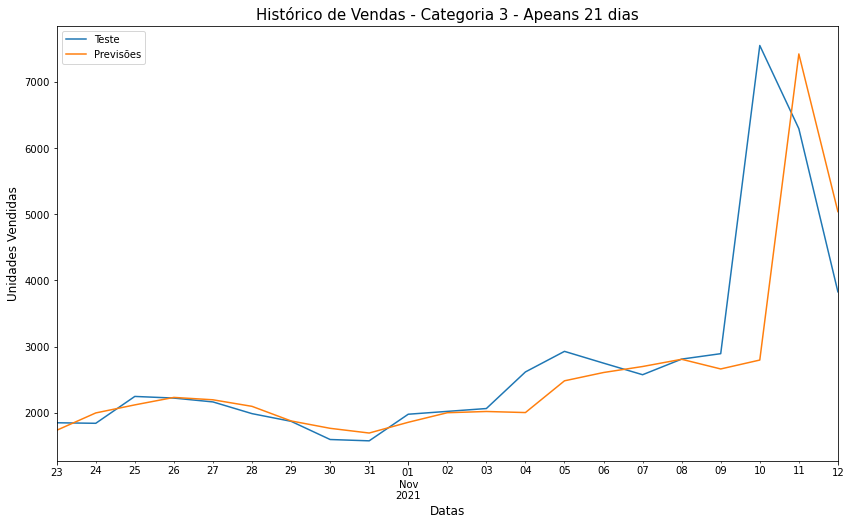

In [86]:
# Plot do Gráfico para os 21 dias
# Define o tamanho da figura
plt.figure(figsize = (14, 8))

# Define o titulo do gráfico
plt.title('Histórico de Vendas - Categoria 3 - Apeans 21 dias', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Cria os gráficos 
test3['UNITS_SOLD'].plot(legend = True, label = 'Teste')
predicts_inverse3.plot(legend = True)

# Mostra o gráfico
plt.show()

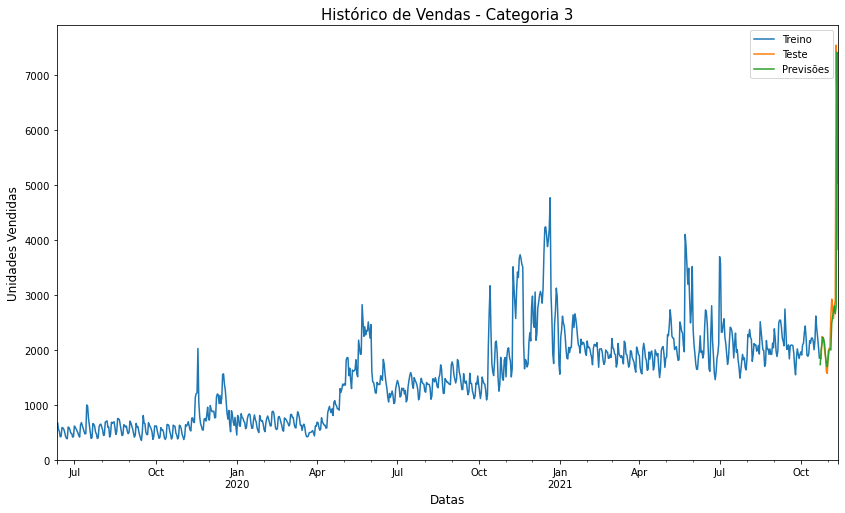

In [87]:
# Plot do Gráfico Completo
# Define o tamanho da figura
plt.figure(figsize = (14, 8))

# Define o titulo do gráfico
plt.title('Histórico de Vendas - Categoria 3', fontsize = 15)

# Define os titulos de X e Y
plt.xlabel('Datas', fontsize = 12)
plt.ylabel('Unidades Vendidas', fontsize = 12)

# Cria os gráficos 
train3['UNITS_SOLD'].plot(legend = True, label = 'Treino')
test3['UNITS_SOLD'].plot(legend = True, label = 'Teste')
predicts_inverse3.plot(legend = True)

# Mostra o gráfico
plt.show()

A partir do comparativo entre preditos e esperados e pelos gráficos, nota-se que ficou bem adequado a aderência do modelo SARIMA a série temporal. Resta agora gerar as predições para dados futuros:

In [88]:
# Definindo a nova janela de predições para 21 dias
start3 = len(series_cat3)
end3   = len(series_cat3) + 21

# Obtendo as  novas predições
new_predicts3 = results3.predict(start = start3, 
                                 end = end3, 
                                 dynamic = False, 
                                 typ = 'levels').rename('Novas Previsões')

In [89]:
# Retornando da base ln utilizando o e^x
new_predicts_inverse3 = np.e**(new_predicts3)

# visualiza as novas predições
new_predicts_inverse3

2021-11-13    3088.010259
2021-11-14    3048.799847
2021-11-15    3449.030368
2021-11-16    3373.318637
2021-11-17    3614.925153
2021-11-18    3507.792061
2021-11-19    3222.050555
2021-11-20    2950.236098
2021-11-21    3041.448998
2021-11-22    3498.856111
2021-11-23    3450.900866
2021-11-24    3713.610531
2021-11-25    3613.777336
2021-11-26    3326.293805
2021-11-27    3050.181636
2021-11-28    3146.116303
2021-11-29    3618.345727
2021-11-30    3569.962439
2021-12-01    3841.038028
2021-12-02    3738.689478
2021-12-03    3442.897746
2021-12-04    3158.577312
Freq: D, Name: Novas Previsões, dtype: float64

## 